<h1 style="color: red;">📋 News Classifier</h1>


* imports : 

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from functions.data_loader import load_data
from functions.analyse_exploratoire import repartition_classes, analyse_len_text, plot_wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud



c:\Users\ramas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2 style="color:#4CAF50;">📌 Partie 1 : Préparation des données</h2>



<h3 style="color:#FF5722;">🔧 Chargement du dataset</h3>


In [2]:

df_train, df_test = load_data()

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
df_train.head()

Loading dataset SetFit/ag_news
Dataset loaded successfully.
Train shape: (120000, 3)
Test shape: (7600, 3)


,text,label,label_text
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


In [3]:
df_train.columns

Index(['text', 'label', 'label_text'], dtype='object')

In [4]:
print("\nla destribution des labels train : ", df_train['label_text'].value_counts())
print("\nla destribution des labels test : ", df_train['label_text'].value_counts())


la destribution des labels train :  label_text
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64

la destribution des labels test :  label_text
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


<h3 style="color:#FF5722;">📊 Analyse exploratoire (EDA)</h3>


* la répartition des classes

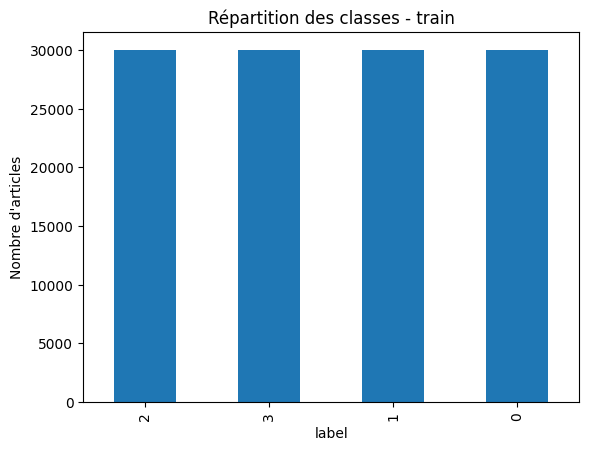

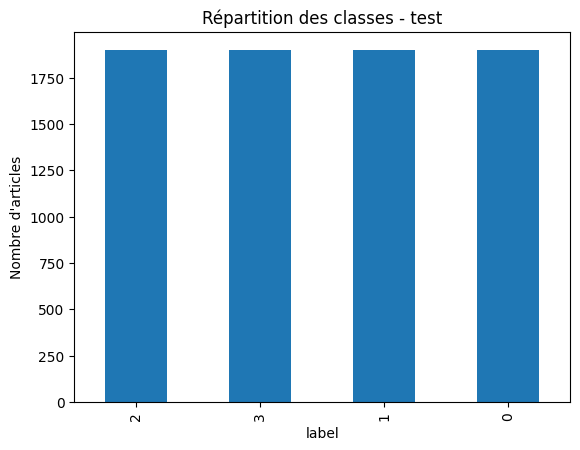

In [5]:
repartition_classes(df_train, "label", "train")
repartition_classes(df_test, "label", "test")


* Analyse des longueurs des textes

****************************************************************************************************
Partie Train : 

                                                text  label label_text  \
0  Wall St. Bears Claw Back Into the Black (Reute...      2   Business   
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   Business   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   Business   
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   Business   
4  Oil prices soar to all-time record, posing new...      2   Business   

   text_length  
0          144  
1          266  
2          232  
3          256  
4          234  
 count    120000.000000
mean        236.477525
std          66.509741
min         100.000000
25%         196.000000
50%         232.000000
75%         266.000000
max        1012.000000
Name: text_length, dtype: float64


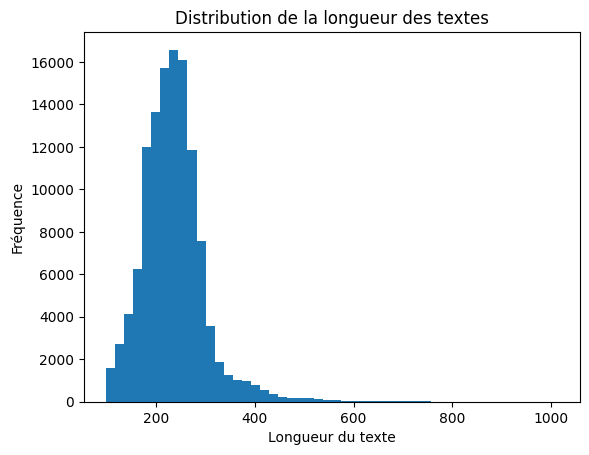

In [6]:
print("****"*25)
print("Partie Train : \n")
analyse_len_text(df_train, "text")

****************************************************************************************************
Partie Test : 

                                                text  label label_text  \
0  Fears for T N pension after talks Unions repre...      2   Business   
1  The Race is On: Second Private Team Sets Launc...      3   Sci/Tech   
2  Ky. Company Wins Grant to Study Peptides (AP) ...      3   Sci/Tech   
3  Prediction Unit Helps Forecast Wildfires (AP) ...      3   Sci/Tech   
4  Calif. Aims to Limit Farm-Related Smog (AP) AP...      3   Sci/Tech   

   text_length  
0          161  
1          321  
2          260  
3          318  
4          223  
 count    7600.000000
mean      235.299211
std        65.302023
min       100.000000
25%       196.750000
50%       231.000000
75%       266.000000
max       892.000000
Name: text_length, dtype: float64


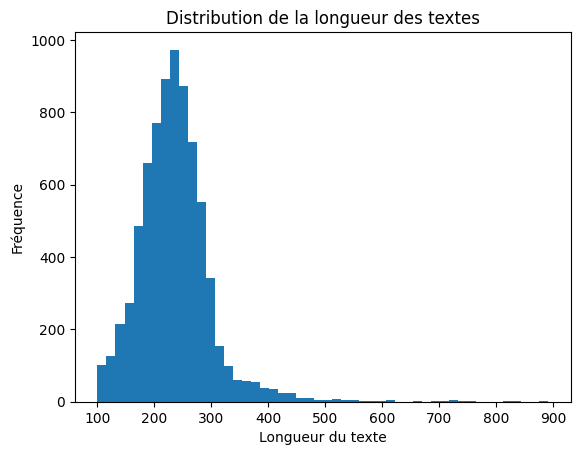

In [7]:
print("****"*25)
print("Partie Test : \n")
analyse_len_text(df_test, "text")

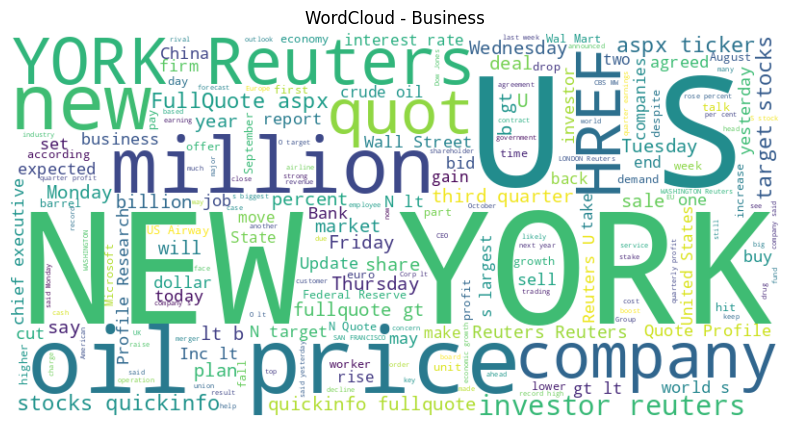

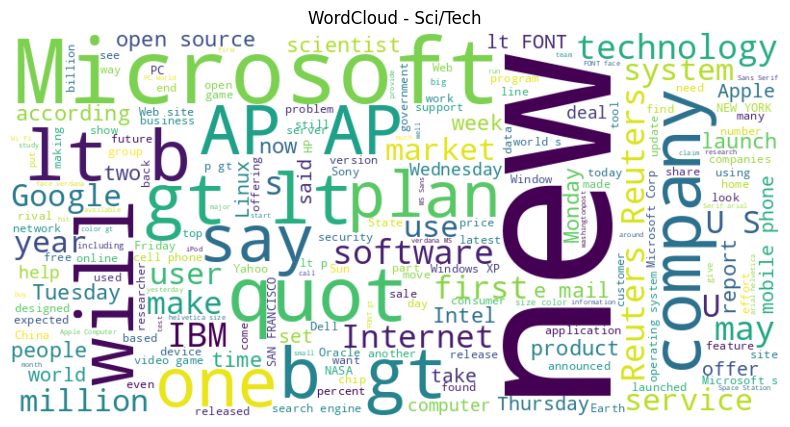

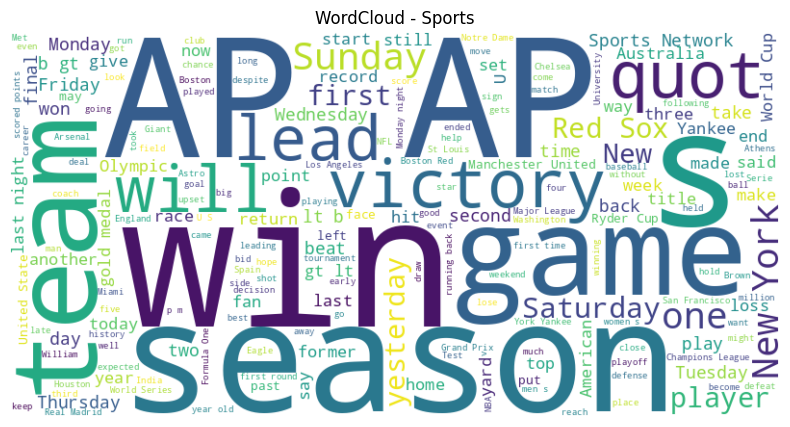

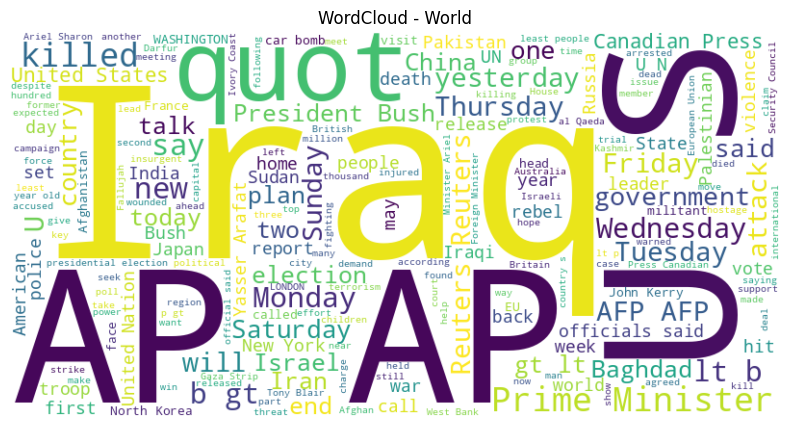

In [8]:


labels_map = df_train["label_text"].unique()

for label_id, label_name in enumerate(labels_map):

    category_texts = df_train[df_train['label_text'] == label_name]['text'].astype(str)

    text_combined = " ".join(category_texts.tolist())

    plot_wordcloud(text_combined, f"WordCloud - {label_name}")


***

<h2 style="color:#4CAF50;">📌 Partie 2 : Prétraitement NLP</h2>

<h3 style="color:#FF5722;">🔧 Nettoyage des textes</h3>